<a href="https://colab.research.google.com/github/norgaston/laboratorio2-mlbd/blob/main/Laboratorio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importa las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Carga tus datos en un DataFrame de Pandas
ruta = '/content/Canciones_Spotify.csv' # ruta desde donde voy a cargar el dataset
data = pd.read_csv(ruta, index_col=0, encoding='latin-1')
data.head()

In [5]:
# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['No Gusta', 'Gusta'], rotation=45)
    plt.yticks(tick_marks, ['No Gusta', 'Gusta'])
    plt.tight_layout()
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')

# Función para graficar la curva ROC y calcular el AUC
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

K-Nearest Neighbors:
[[114  92]
 [ 85 113]]
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       206
           1       0.55      0.57      0.56       198

    accuracy                           0.56       404
   macro avg       0.56      0.56      0.56       404
weighted avg       0.56      0.56      0.56       404



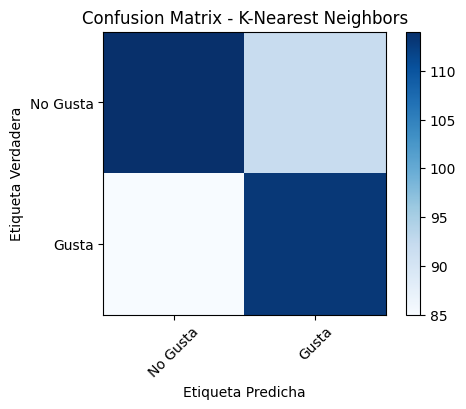

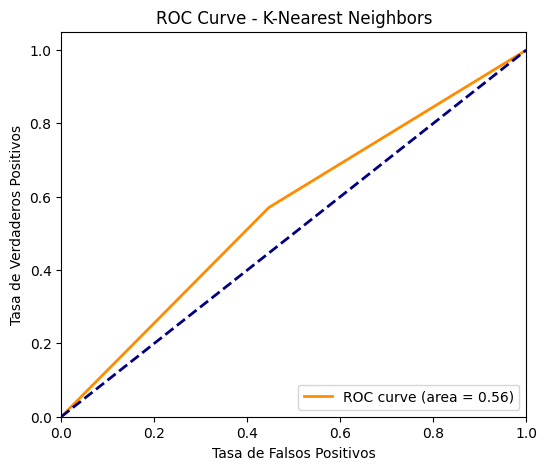

Support Vector Machine:
[[108  98]
 [ 82 116]]
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       206
           1       0.54      0.59      0.56       198

    accuracy                           0.55       404
   macro avg       0.56      0.56      0.55       404
weighted avg       0.56      0.55      0.55       404



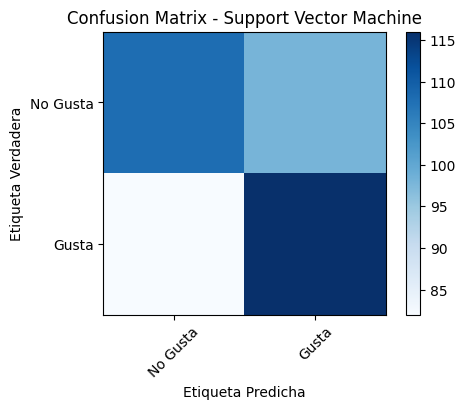

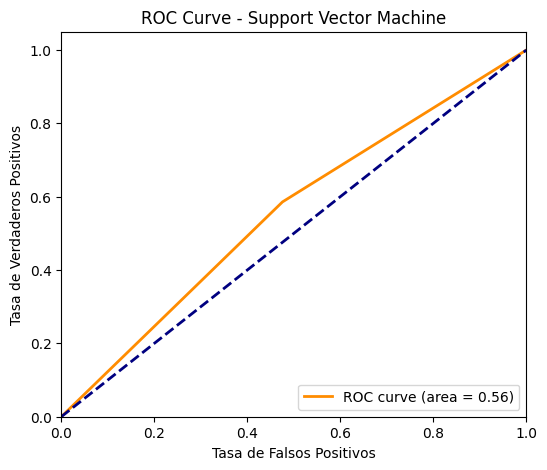

Decision Tree:
[[143  63]
 [ 52 146]]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       206
           1       0.70      0.74      0.72       198

    accuracy                           0.72       404
   macro avg       0.72      0.72      0.72       404
weighted avg       0.72      0.72      0.72       404



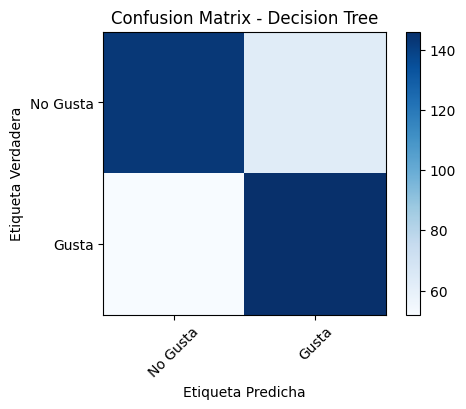

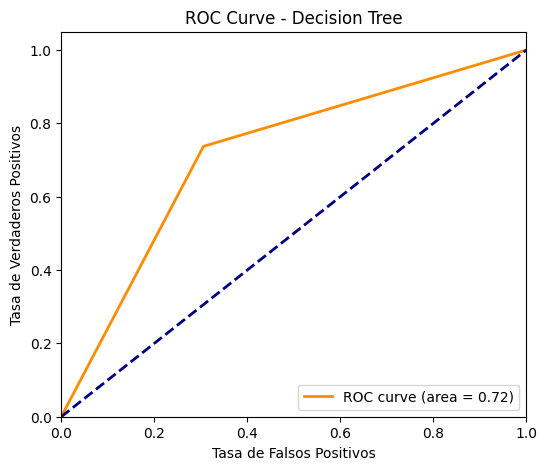

Naive Bayes:
[[126  80]
 [ 81 117]]
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       206
           1       0.59      0.59      0.59       198

    accuracy                           0.60       404
   macro avg       0.60      0.60      0.60       404
weighted avg       0.60      0.60      0.60       404



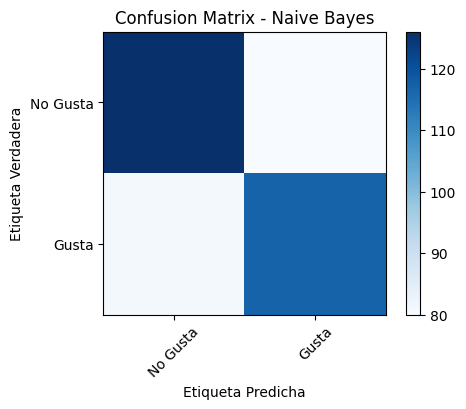

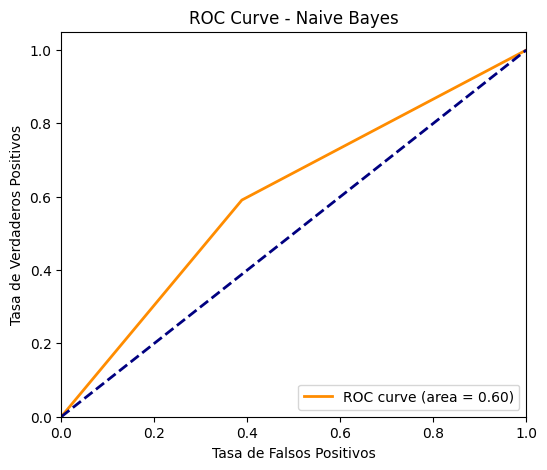

Ensamble (Votación Mayoritaria):
[[158  48]
 [ 95 103]]
              precision    recall  f1-score   support

           0       0.62      0.77      0.69       206
           1       0.68      0.52      0.59       198

    accuracy                           0.65       404
   macro avg       0.65      0.64      0.64       404
weighted avg       0.65      0.65      0.64       404



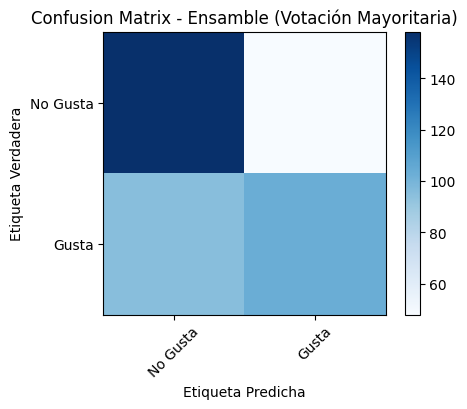

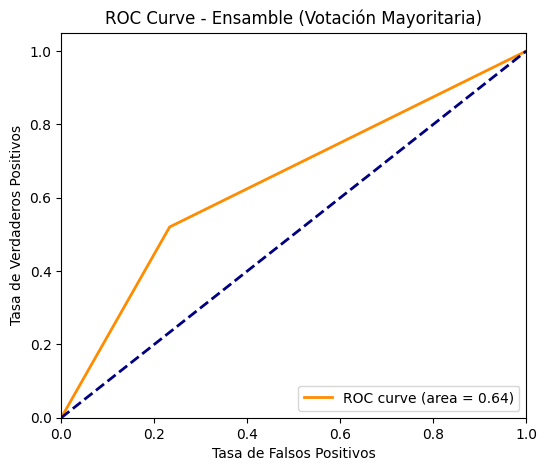

In [6]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data.drop(['target', 'song_title', 'artist'], axis=1)
y = data['target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelos
knn_model = KNeighborsClassifier(n_neighbors=5)
svm_model = SVC(kernel='linear')
decision_tree_model = DecisionTreeClassifier(max_depth=5)
naive_bayes_model = GaussianNB()

knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
naive_bayes_model.fit(X_train, y_train)

# Realizar predicciones
knn_predictions = knn_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)

# Evaluar modelos
print("K-Nearest Neighbors:")
print(confusion_matrix(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))

# Graficar matriz de confusión y curva ROC para cada modelo
plot_confusion_matrix(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()
plot_roc_curve(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()

print("Support Vector Machine:")
print(confusion_matrix(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

plot_confusion_matrix(y_test, svm_predictions, 'Support Vector Machine')
plt.show()
plot_roc_curve(y_test, svm_predictions, 'Support Vector Machine')
plt.show()

print("Decision Tree:")
print(confusion_matrix(y_test, decision_tree_predictions))
print(classification_report(y_test, decision_tree_predictions))

plot_confusion_matrix(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()
plot_roc_curve(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()

print("Naive Bayes:")
print(confusion_matrix(y_test, naive_bayes_predictions))
print(classification_report(y_test, naive_bayes_predictions))

plot_confusion_matrix(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()
plot_roc_curve(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()

# Ensamble de modelos (Votación mayoritaria)
ensemble_model = VotingClassifier(estimators=[('KNN', knn_model), ('SVM', svm_model), ('DecisionTree', decision_tree_model), ('NaiveBayes', naive_bayes_model)], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)

# Evaluar el ensamble
print("Ensamble (Votación Mayoritaria):")
print(confusion_matrix(y_test, ensemble_predictions))
print(classification_report(y_test, ensemble_predictions))

plot_confusion_matrix(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()
plot_roc_curve(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()

**Conclusiones:**

En esta tabla, puedes ver claramente cómo cada modelo se desempeña en términos de precisión, recall, f1-score y exactitud para ambas clases.

---



| Modelo                        | Precisión (Clase 0) | Recall (Clase 0) | F1-Score (Clase 0) | Precisión (Clase 1) | Recall (Clase 1) | F1-Score (Clase 1) | F1-Score Promedio | Exactitud |
|-------------------------------|---------------------|-------------------|--------------------|---------------------|-------------------|--------------------|--------------------|-----------|
| Decision Tree                 | 0.73                | 0.69              | 0.71               | 0.70                | 0.74              | 0.72               | 0.72               | 0.72      |
| Ensamble (Votación Mayoritaria)| 0.62                | 0.77              | 0.69               | 0.68                | 0.52              | 0.59               | 0.64               | 0.65      |
| Naive Bayes                   | 0.61                | 0.61              | 0.61               | 0.59                | 0.59              | 0.59               | 0.60               | 0.60      |
| K-Nearest Neighbors (KNN)     | 0.57                | 0.55              | 0.56               | 0.55                | 0.57              | 0.56               | 0.56               | 0.56      |
| Support Vector Machine (SVM)  | 0.57                | 0.52              | 0.55               | 0.54                | 0.59              | 0.56               | 0.55               | 0.55      |


El modelo Decision Tree tiene el mejor rendimiento en general, seguido por el modelo de Ensamble (Votación Mayoritaria). Las otras opciones, como K-Nearest Neighbors, Support Vector Machine y Naive Bayes, muestran un rendimiento inferior en este escenario. La elección del modelo dependerá de los objetivos específicos del proyecto y de las características del conjunto de datos.